<b> IMPORTS

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
%matplotlib inline

<b> INSPECT THE DATA

In [2]:
# Check the mpl version (3.1.1 causes issues with seaborn)
matplotlib.__version__

'3.1.3'

In [3]:
# command for readable pandas formatting
pd.options.display.float_format = "{:.2f}".format

In [4]:
# Load the data
df = pd.read_csv('data-final.csv', sep='\t')

In [5]:
# Inspect the data
df.head(1)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.00,1.00,5.00,2.00,5.00,1.00,5.00,2.00,4.00,1.00,...,2016-03-03 02:01:01,768.00,1024.00,9.00,234.00,6,1,GB,51.5448,0.1991


In [6]:
# Inspect the data shape
print('Number of rows:',df.shape[0])

Number of rows: 1015341


In [7]:
# Classify the columns to categorical and numerical
num_cols = df._get_numeric_data().columns
cat_cols = [col for col in df.columns if col not in num_cols]
print('Number of columns:',len(df.columns),
      f' (numerical:{len(num_cols)},',
      f' categorical:{len(cat_cols)})')

Number of columns: 110  (numerical:106,  categorical:4)


<b> CLEAN THE DATA

In [8]:
# First step of cleaning- IPC.
# Limit the analysis to IPC =1 to get rid of duplicated submissions.
"""
As per Kaggle dataset description:
The number of records from the user's IP address in the dataset. 
For max cleanliness, only use records where this value is 1. 
High values can be because of shared networks (e.g. entire universities) or multiple submissions
"""
df = df.loc[df['IPC']==1]

In [9]:
# Get rid of invalid results 
# As the answers are in scale 1 to 5, we want to delete invalid inputs 
df = df.loc[(df[df.columns.tolist()[:49]] >= 1).all(axis=1)]

In [10]:
# positive questions adding to the trait.
pos_questions = [ 
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7
]

# negative (negating) questions subtracting from the trait.
neg_questions = [ 
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5
    'EST2','EST4',                       # 2
    'AGR1','AGR3','AGR5','AGR7',         # 4
    'CSN2','CSN4','CSN6','CSN8',         # 4
    'OPN2','OPN4','OPN6',                # 3
]

df[pos_questions] = df[pos_questions].replace({1:-2, 2:-1, 3:0, 4:1, 5:2})
df[neg_questions] = df[neg_questions].replace({1:2, 2:1, 3:0, 4:-1, 5:-2})

In [11]:
# Check for missing data.
df.isna().mean().sum()

0.003193550682311204

In [12]:
df = df.dropna()
df.isna().mean().sum()

0.0

In [13]:
# columns with time spent answering questions
qtime_cols = list(df.columns)[50:100]

In [14]:
# Check if selected correct columns
qtime_cols[0], qtime_cols[-1]

('EXT1_E', 'OPN10_E')

In [15]:
# Calculate the total time for each survey
df['total_time']=df[qtime_cols].sum(axis=1)

In [16]:
df['total_time'].describe()

count       603661.00
mean        477107.67
std        7805683.05
min      -78732580.00
25%         166858.00
50%         215851.00
75%         296094.00
max     2147710653.00
Name: total_time, dtype: float64

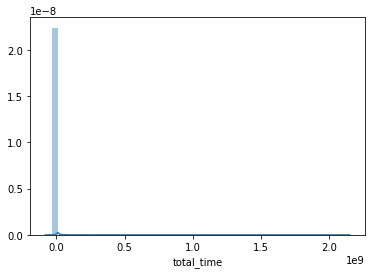

In [17]:
# Can't see anything due to large outliers
ax = sns.distplot(df['total_time'])

In [18]:
# See how much data will be lost if we get rid of the outliers
total_respondents = len(df)
fast_respondents = len(df[df['total_time']<10000])
slow_respondents = len(df[df['total_time']>1000000])

print("Total respondents:",total_respondents)
print("Slowest respondents:",slow_respondents/total_respondents)
print("Fastest respondents:",fast_respondents/total_respondents)

Total respondents: 603661
Slowest respondents: 0.025920177053014856
Fastest respondents: 0.002668716382207895


In [19]:
df = df[df['total_time'].between(10000,1000000)]

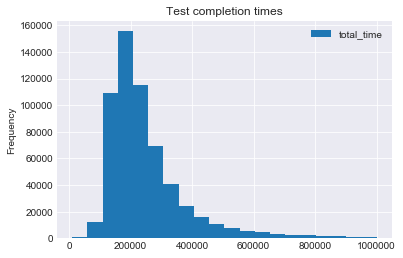

In [20]:
from matplotlib import style
style.use("seaborn-darkgrid")
df[['total_time']].plot(kind='hist',bins=20)
plt.title('Test completion times')
plt.show()

In [21]:
# List the redundant cols such as longitude and latitudee
drop_cols=list(df.columns[50:107])+['lat_appx_lots_of_err','long_appx_lots_of_err']

In [22]:
# Drop the redundant cols
df=df.drop((drop_cols), axis=1)

In [23]:
df

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country,total_time
0,1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,2.00,...,1.00,2.00,1.00,2.00,2.00,0.00,1.00,2.00,GB,232186.00
1,0.00,-2.00,0.00,-1.00,0.00,0.00,-1.00,-2.00,-2.00,-2.00,...,1.00,1.00,0.00,2.00,1.00,-1.00,2.00,0.00,MY,176901.00
2,-1.00,0.00,1.00,-1.00,0.00,1.00,-2.00,0.00,-1.00,-2.00,...,-1.00,2.00,1.00,1.00,2.00,0.00,1.00,1.00,GB,184540.00
3,-1.00,1.00,-1.00,0.00,1.00,1.00,-1.00,-1.00,-2.00,-1.00,...,2.00,1.00,0.00,2.00,1.00,1.00,0.00,0.00,GB,218262.00
5,0.00,0.00,1.00,1.00,1.00,1.00,-1.00,0.00,0.00,-1.00,...,2.00,2.00,0.00,2.00,2.00,1.00,2.00,-1.00,SE,192377.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015334,1.00,2.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,...,2.00,0.00,1.00,1.00,2.00,-1.00,0.00,1.00,GB,207093.00
1015335,2.00,2.00,2.00,1.00,1.00,1.00,0.00,2.00,2.00,2.00,...,1.00,1.00,0.00,1.00,2.00,0.00,1.00,1.00,TR,243426.00
1015337,1.00,0.00,1.00,0.00,0.00,0.00,1.00,-1.00,0.00,0.00,...,2.00,2.00,2.00,2.00,0.00,1.00,2.00,1.00,US,121746.00
1015339,-1.00,-1.00,0.00,-1.00,-1.00,1.00,-2.00,-1.00,-1.00,-1.00,...,1.00,1.00,0.00,1.00,1.00,2.00,2.00,0.00,US,211104.00


In [24]:
# List the number of unique countries, count them
countries = df['country'].unique()
len(countries)

220

In [25]:
# A list of all EU countries, count them
EU = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]
len(EU)

28

In [26]:
# Check if all EU countries are in the data
intersection = set(EU).intersection(set(countries))
len(intersection)

28

In [27]:
# Limit the analysis to EU countries
df = df.loc[df['country'].isin(EU)]

In [28]:
# Count responses by country
df['country'].value_counts()[:5]

GB    42598
DE    10575
NL     6700
SE     6344
FR     4390
Name: country, dtype: int64

In [29]:
# This gives us percentage of responses from each country
df['country'].value_counts(normalize=True) * 100

GB   38.43
DE    9.54
NL    6.04
SE    5.72
FR    3.96
IT    3.32
ES    3.22
PL    3.13
IE    3.11
FI    2.98
DK    2.93
RO    2.53
BE    2.16
PT    1.71
GR    1.69
AT    1.51
HR    1.44
CZ    1.19
HU    1.02
BG    0.87
LT    0.72
EE    0.65
SK    0.61
SI    0.57
LV    0.36
MT    0.25
CY    0.18
LU    0.15
Name: country, dtype: float64

In [30]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country,total_time
0,1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,2.00,...,1.00,2.00,1.00,2.00,2.00,0.00,1.00,2.00,GB,232186.00
2,-1.00,0.00,1.00,-1.00,0.00,1.00,-2.00,0.00,-1.00,-2.00,...,-1.00,2.00,1.00,1.00,2.00,0.00,1.00,1.00,GB,184540.00
3,-1.00,1.00,-1.00,0.00,1.00,1.00,-1.00,-1.00,-2.00,-1.00,...,2.00,1.00,0.00,2.00,1.00,1.00,0.00,0.00,GB,218262.00
5,0.00,0.00,1.00,1.00,1.00,1.00,-1.00,0.00,0.00,-1.00,...,2.00,2.00,0.00,2.00,2.00,1.00,2.00,-1.00,SE,192377.00
9,-2.00,-2.00,0.00,-2.00,-1.00,0.00,-1.00,-1.00,2.00,-1.00,...,0.00,2.00,0.00,0.00,1.00,0.00,0.00,0.00,FI,249953.00


<b> FEATURE ENGINEERING

In [31]:
# Create an aggregated feature for each of the five personality dimensions.
# They will average the 10 answers across the dimension.

# Extraversion 
EXT = list(df.columns[:10])
# Emotional Stability
EST = list(df.columns[10:20])
# Agreeableness
AGR = list(df.columns[20:30])
# Conscientiousness
CSN = list(df.columns[30:40])
# Openness
OPN = list(df.columns[40:50])

dimensions = [EXT,EST,AGR,CSN,OPN]
dimension_averages=["extraversion","emotional_stability",
       "agreeableness","conscientiousness","openness"]

In [32]:
for d in range(len(dimensions)):
    df[dimension_averages[d]] = df[dimensions[d]].mean(axis=1)

/Users/gajdulj/opt/anaconda3/envs/gajdulj/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<b> ANALYSE THE DATA

In [33]:
df.head(1)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN8,OPN9,OPN10,country,total_time,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,2.00,...,0.00,1.00,2.00,GB,232186.00,1.60,-0.60,0.90,0.20,1.50


In [34]:
# Analyse the aggregated features
df[dimension_averages].describe()

,extraversion,emotional_stability,agreeableness,conscientiousness,openness
count,110841.00,110841.00,110841.00,110841.00,110841.00
mean,-0.10,0.13,0.66,0.22,1.00
std,0.92,0.86,0.76,0.73,0.60
min,-2.00,-2.00,-2.00,-2.00,-2.00
25%,-0.80,-0.50,0.20,-0.30,0.60
50%,-0.10,0.20,0.80,0.20,1.10
75%,0.60,0.80,1.20,0.70,1.50
max,2.00,2.00,2.00,2.00,2.00


<b> VISUALISE THE DATA

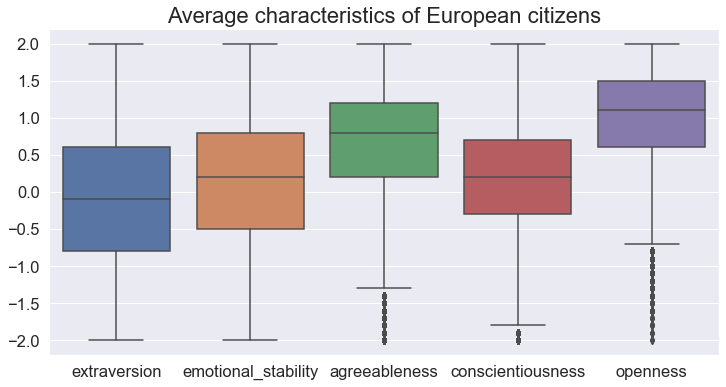

In [35]:
# Use a boxlot to visualise the 5 variables
# This method will give us a good overview of the distribution across the variables
sns.set_style("darkgrid")

#reset default parameters
sns.set()
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.5)
sns.boxplot(data=df[dimension_averages]);
plt.title("Average characteristics of European citizens",fontsize=22)
plt.savefig('avg_char.png')
plt.show()

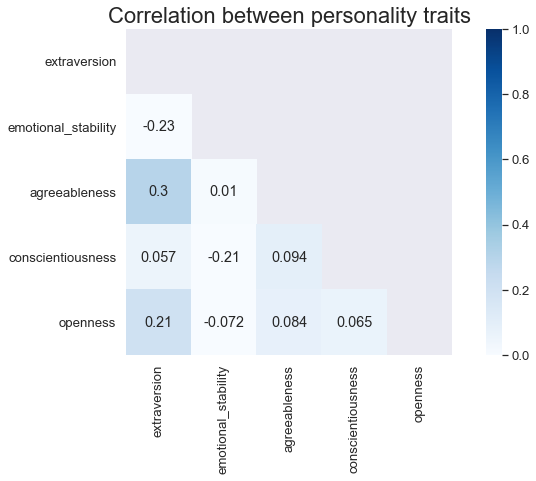

In [36]:
#reset default parameters
sns.set()
plt.figure(figsize=(12, 6))

# Visualise the correlation
corr=df[dimension_averages].corr()
mask = np.triu(corr)
sns.set(font_scale=1.2)
sns.heatmap(df[dimension_averages].corr(),
            vmin=0,
            vmax=1,
            annot = True,
            square=True, 
            mask=mask,
            cbar=True,
            cmap='Blues')
plt.title('Correlation between personality traits',fontsize=22)
plt.savefig('correlations.png')
plt.show()

In [37]:
# Subset df to only those with country GB, PL
gb = df.loc[df['country']=="GB"]
pl = df.loc[df['country']=="PL"]

In [38]:
# Limit the analysis to two countries and averages across 5 dimensions
gb = gb[gb.columns[-6:]]
pl = pl[pl.columns[-6:]]

In [39]:
def transpose_table(df, col_list):
    """
    INPUT 
        df - a dataframe holding the col_list columns
        col_list- columns that we want to transpose into rows
        
    OUTPUT
        new_df- a transposed dataframe.
    """
    new_df = defaultdict(int)
    for i in col_list:
        new_df[i]=df[i].mean()
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.rename(columns={'index': 'personality', 0: 'average'}, inplace=True)
    new_df.set_index('personality', inplace=True)
    return new_df 

In [40]:
dimension_averages

['extraversion',
 'emotional_stability',
 'agreeableness',
 'conscientiousness',
 'openness']

In [41]:
gb_avg = transpose_table(gb,dimension_averages)
pl_avg = transpose_table(pl,dimension_averages)
comp_df = pd.merge(gb_avg, pl_avg, left_index=True, right_index=True)
comp_df.columns = ['gb_avg', 'pl_avg']
comp_df['value_difference'] = comp_df['gb_avg'] - comp_df['pl_avg']
comp_df.style.bar(subset=['value_difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_avg,pl_avg,value_difference
personality,,,
extraversion,-0.081715,-0.311432,0.229717
emotional_stability,0.188626,0.275433,-0.086807
agreeableness,0.690457,0.383863,0.306595
conscientiousness,0.228640,0.104619,0.124021
openness,0.952033,1.090300,-0.138267


In [42]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN8,OPN9,OPN10,country,total_time,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,2.00,...,0.00,1.00,2.00,GB,232186.00,1.60,-0.60,0.90,0.20,1.50
2,-1.00,0.00,1.00,-1.00,0.00,1.00,-2.00,0.00,-1.00,-2.00,...,0.00,1.00,1.00,GB,184540.00,-0.50,-0.40,1.20,0.40,1.10
3,-1.00,1.00,-1.00,0.00,1.00,1.00,-1.00,-1.00,-2.00,-1.00,...,1.00,0.00,0.00,GB,218262.00,-0.40,-0.10,0.80,-0.50,0.90
5,0.00,0.00,1.00,1.00,1.00,1.00,-1.00,0.00,0.00,-1.00,...,1.00,2.00,-1.00,SE,192377.00,0.20,-0.80,0.80,0.70,1.40
9,-2.00,-2.00,0.00,-2.00,-1.00,0.00,-1.00,-1.00,2.00,-1.00,...,0.00,0.00,0.00,FI,249953.00,-0.80,0.10,-1.10,-1.30,0.50


In [43]:
# Add binary column to indicate if Great Britain 
df['is_gb'] = df['country'].apply(lambda x: 1 if x =='GB' else 0)

/Users/gajdulj/opt/anaconda3/envs/gajdulj/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<b> MODELLING

In [44]:
# Copy the dataframe
df_ml = df.copy()

to_drop =["country","total_time"]
          #+["extraversion","emotional_stability","agreeableness","conscientiousness","openness"]
    
# Delete old column indicating country
df_ml = df_ml.drop(columns=to_drop)

# Shuffle the data to ensure that split is fair
df_ml = df_ml.sample(n=len(df_ml),random_state=42)

<b> CORRELATIONS

In [45]:
corr_data = pd.DataFrame(df_ml.corr()['is_gb'][:])

In [46]:
corr_data = corr_data.reset_index()

In [47]:
corr_data = corr_data.sort_values(by=['is_gb'])

In [48]:
corr_data[:3]

,index,is_gb
22,AGR3,-0.09
54,openness,-0.07
46,OPN7,-0.07


In [49]:
corr_data[-4:-1]

,index,is_gb
37,CSN8,0.10
20,AGR1,0.11
18,EST9,0.12


In [50]:
top_correlation = corr_data.sort_values('is_gb', ascending=False).head(10)['index'].to_list()
least_correlation = corr_data.sort_values('is_gb', ascending=False).tail(5)['index'].to_list()

In [51]:
# Count the outcome variables to identify the baseline
positives = len(df.loc[df_ml['is_gb']==1])
negatives = len(df.loc[df_ml['is_gb']==0])
1-(positives/(positives+negatives))

0.615683727140679

In [52]:
# Select the dependent variable
Y = df_ml['is_gb']
X = df_ml.drop('is_gb',axis=1)

In [53]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

<b> XGBOOST

In [54]:
import xgboost as xgb

# Instantiate the model
xgb_model = xgb.XGBClassifier(learning_rate=0.05, 
              max_depth=3,
              gamma=0.08435594187707007,
              colsample_bytree=0.5336629698328548,
              n_estimators=1000, 
              objective='binary:logistic', 
              random_state=42)

# fit model to training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5336629698328548,
              gamma=0.08435594187707007, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.05,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [55]:
# make predictions for test data
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.10%


In [56]:
# Find optimal threshold
thresholds=(np.linspace(0.45,0.50,20))
for t in thresholds:
    predictions=xgb_model.predict_proba(X_test)[:,1]>t
    print("AUC for threshold",t,":",
         roc_auc_score(y_test, predictions))
    accuracy = accuracy_score(y_test, predictions)
    print("XGB Classifier accuracy: %.2f%%" % (accuracy * 100.0))

AUC for threshold 0.45 : 0.6607593767239239
XGB Classifier accuracy: 69.01%
AUC for threshold 0.45263157894736844 : 0.6592229880561976
XGB Classifier accuracy: 68.97%
AUC for threshold 0.45526315789473687 : 0.6580273661915944
XGB Classifier accuracy: 68.96%
AUC for threshold 0.4578947368421053 : 0.6578843866611415
XGB Classifier accuracy: 69.06%
AUC for threshold 0.4605263157894737 : 0.6566900926329737
XGB Classifier accuracy: 69.07%
AUC for threshold 0.4631578947368421 : 0.6557825207405463
XGB Classifier accuracy: 69.11%
AUC for threshold 0.46578947368421053 : 0.6550975123415499
XGB Classifier accuracy: 69.16%
AUC for threshold 0.46842105263157896 : 0.6544891778743822
XGB Classifier accuracy: 69.20%
AUC for threshold 0.4710526315789474 : 0.654021675981353
XGB Classifier accuracy: 69.26%
AUC for threshold 0.4736842105263158 : 0.6530084160687523
XGB Classifier accuracy: 69.27%
AUC for threshold 0.4763157894736842 : 0.6523548230726929
XGB Classifier accuracy: 69.31%
AUC for threshold 0.4

In [57]:
69/61

1.1311475409836065

In [58]:
# Check the most important features
importance = xgb_model.get_booster().get_score(importance_type= 'gain')
sorted(importance.items(), key=lambda x:x[1],reverse=True)[:3]

[('AGR3', 75.12803502181251),
 ('CSN8', 71.79966872000004),
 ('EST9', 68.63692929306221)]

<b> Question code mapping
    
AGR3: I insult people
    
CSN8: I shirk my duties
    
EST9: I get irritated easily

In [59]:
gb_df = df.loc[df['is_gb']==1]
eu_df = df.loc[df['is_gb']==0]
comp_metrics = ['AGR3','CSN8','EST9']

gb_df = transpose_table(gb_df,comp_metrics)
eu_df = transpose_table(eu_df,comp_metrics)
comp_df = pd.merge(gb_df, eu_df, left_index=True, right_index=True)
comp_df.columns = ['gb_avg','eu_avg']
comp_df['value_difference'] = comp_df['gb_avg'] - comp_df['eu_avg']
comp_df.style.bar(subset=['value_difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_avg,eu_avg,value_difference
personality,,,
AGR3,0.509390,0.753000,-0.243610
CSN8,0.452909,0.226514,0.226395
EST9,0.311353,0.007268,0.304085
